<a href="https://colab.research.google.com/github/mikiereed/automate_python_test_code/blob/master/Airline_Arrival_Delays_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial URL https://towardsdatascience.com/learn-python-data-analytics-by-example-airline-arrival-delays-e26356e8ae6b

In [ ]:
import pandas as pd
import matplotlib as plt

delays_2018_url = 'https://raw.githubusercontent.com/nickdcox/learn-airline-delays/main/delays_2018.csv'
delays_2019_url = 'https://raw.githubusercontent.com/nickdcox/learn-airline-delays/main/delays_2019.csv'

df_delays_2018 = pd.read_csv(delays_2018_url)
df_delays_2019 = pd.read_csv(delays_2019_url)

df_delays = pd.concat([df_delays_2018, df_delays_2019], ignore_index=True)

print(f'Number of 2018 Rows, 2019 Rows: {len(df_delays_2018)}, {len(df_delays_2019)}')
print(f'Number of Rows Combined: {len(df_delays)}')

Number of 2018 Rows, 2019 Rows: 20231, 20946
Number of Rows Combined: 41177


In [ ]:
# Change the data type of the 'month' column to date and change the format to YYYY-M (e.g. 2018-1)
df_delays['date'] = pd.to_datetime(df_delays['date'], format='%Y-%m').dt.strftime('%Y-%m')

# Remove invalid rows
df_delays = df_delays[(df_delays['date'] >= '2018-01') & 
                      (df_delays['date'] <= '2019-12') & 
                      (df_delays['arr_flights'].notnull()) & 
                      (df_delays['carrier'].notnull()) & 
                      (df_delays['carrier_name'].notnull()) & 
                      (df_delays['airport'].notnull()) & 
                      (df_delays['airport_name'].notnull())]

# Print out the number of rows remaining in the dataset
print(f'Number of Rows: {len(df_delays)}')

Number of Rows: 41077


In [ ]:
# Identify the airports in the state of Tennessee.
df_delays['TN'] = df_delays['airport_name'].apply(lambda x: x.find('TN'))

# Create a set of airport names (to eliminate the duplicates).
airports = set(df_delays[df_delays['TN'] != -1]['airport_name'])

# Display the list of airports.
print(f'Tennessee Airports:\n {airports}')

Tennessee Airports:
 {'Chattanooga, TN: Lovell Field', 'Nashville, TN: Nashville International', 'Knoxville, TN: McGhee Tyson', 'Memphis, TN: Memphis International', 'Bristol/Johnson City/Kingsport, TN: Tri Cities'}


In [ ]:
# Read the coordinates file and import all rows.
df_coords = pd.read_csv('https://raw.githubusercontent.com/nickdcox/learn-airline-delays/main/airport_coordinates.csv')

# Create a new DataFrame with airport codes and names.
df_airports = df_delays[['airport', 'airport_name']].drop_duplicates().reset_index(drop=True)

# Merge the coordinates DataFrame with the airports DataFrame.
df_airports = pd.merge(df_airports, df_coords, on='airport')

print(df_airports.head(3))


  airport                             airport_name        lat        long
0     BIS  Bismarck/Mandan, ND: Bismarck Municipal  46.778889 -100.752500
1     BNA   Nashville, TN: Nashville International  36.126667  -86.681944
2     BOI            Boise, ID: Boise Air Terminal  43.565278 -116.225000


In [ ]:
# Use crosstab to display the number of late aircraft delays for each carrier-airport pair, without null values.
pd.crosstab(df_delays['carrier'], df_delays['airport'], values=df_delays['late_aircraft_delay'], aggfunc='sum').fillna('')

airport,ABE,ABI,ABQ,ABR,ABY,ACK,ACT,ACV,ACY,ADK,ADQ,AEX,AGS,AKN,ALB,ALO,AMA,ANC,APN,ART,ASE,ATL,ATW,ATY,AUS,AVL,AVP,AZA,AZO,BDL,BET,BFF,BFL,BFM,BGM,BGR,BHM,BIL,BIS,BJI,...,SMX,SNA,SPI,SPN,SPS,SRQ,STC,STL,STS,STT,STX,SUN,SUX,SWF,SWO,SYR,TLH,TOL,TPA,TRI,TTN,TUL,TUS,TVC,TWF,TXK,TYR,TYS,UIN,USA,VEL,VLD,VPS,WRG,WYS,XNA,XWA,YAK,YNG,YUM
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9E,2787,,,,1397,814,,,,,,5356,8726,,841,,,,,,,400620,4050,,1624,4317,376,,33,12027,,,,,,20135,5124,,241,,...,,,,,,494,,20034,,,,,,,,26423,7642,,1846,3285,,4313,,2179,,,,38105,,,,833,364,,,12530,,,,
AA,,,27962,,,,,,,,,,0,,8075,,3335,4966,,,,124595,,,108103,,,,,50535,,,,,,,509,,,,...,,39184,,,,2051,,93210,,7358,3935,,,,,10567,,,125663,,,40919,37773,,,,,1345,,,,,15191,,,7764,,,,
AS,,,3112,,,,,,,313,1272,,,99,,,,74084,,,,967,,,13825,,,,,,1679,,,,,,,,,,...,,11711,,,,,,2043,,,,,,,,,,,754,,,,1271,,,,,,,,,,,6753,,,,5581,,
B6,,,2008,,,13737,,,,,,,,,5844,,,4075,,,,33983,,,26413,,,,,77640,,,,,,,,,,,...,,,,,,2546,,,,13881,2577,,,10580,,32970,,,63986,,,,,,,,,,,,,,,,,,,,,
DL,1543,,4499,,,,,,,,,,3698,,7416,,,6954,,,,1.44778e+06,2753,,46683,2713,1569,,,14599,,,,,,588,15794,5697,2171,,...,,12597,,,,12477,,18691,,608,92,,,,,6757,4820,,70714,2763,,4008,4870,2333,,,,5417,,,,,11088,,,3583,,,,
EV,3708,,1013,,,,,,,,,7323,796,,3696,,7141,,,,,61005,1200,,51,485,5086,,433,743,,,,,,9829,12441,,91,,...,,,,,,,,22770,,,,,,,,7730,964,,,249,,13381,39,1085,,0,,28507,,,,,4108,,,9787,,,,
F9,,,5452,,,,,,,,,,,,2300,,,,,,,66656,,,66737,,,,,2158,,,,380,,,3109,667,1976,,...,,9950,,,,1867,,26044,,,,,,,,6365,,,53542,,66448,5069,448,,,,368,1787,,,,,,,,344,,,,
G4,6316,,2376,,,,,,,,,,,,861,,,0,,,,,1102,,6055,29479,0,96784,,,,,,,,1407,,3369,1567,,...,527,,1026,,,12649,731,,,,,,,2087,,4199,,1735,,1929,350,1648,329,214,,,,24143,,12136,,,33737,,,2761,,,0,
HA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [ ]:
# Subset DataFrame for planes arriving into JFK in 2019 with values in both the carrier_ct and weather_ct columns.
df_f = df_delays[(df_delays['date'] >= '2019-01') & 
                 (df_delays['date'] <= '2019-12') & 
                 (df_delays['airport'] == 'JFK') & 
                 (df_delays['carrier_ct'] > 0) &
                 (df_delays['weather_ct'] > 0)]

# Add together the sums of the two columns to obtain the total number of delays.
print(f'Number of Delays: {(df_f["carrier_ct"].sum() + df_f["weather_ct"].sum()):.0f}')

Number of Delays: 6919


In [ ]:

# Create a DataFrame containing airline names, total arriving flights and number of cancelled flights.
df_flights = (df_delays.groupby('carrier_name')['arr_flights'].sum()
                       .reset_index(name='num_arrived'))
df_cancelled = (df_delays.groupby('carrier_name')['arr_cancelled'].sum()
                         .reset_index(name='num_cancelled'))
df_cancelled = pd.merge(df_cancelled, df_flights, on='carrier_name')

# Calculate the percentage of flights cancelled.
df_cancelled['proportion'] = df_cancelled['num_cancelled'] / df_cancelled['num_arrived'] * 100

# Display the 5 airlines with the most cancellations as a percentage of total arriving flights.
df_cancelled.sort_values(by=['proportion'], ascending=False).head(5)

,carrier_name,num_cancelled,num_arrived,proportion
7,ExpressJet Airlines LLC,4163.0,97099.0,4.287377
5,Envoy Air,22071.0,622719.0,3.544295
12,PSA Airlines Inc.,18692.0,567735.0,3.292381
6,ExpressJet Airlines Inc.,7589.0,240320.0,3.157873
11,Mesa Airlines Inc.,12239.0,443026.0,2.762592


In [ ]:
# Calculate the average number of delays per airport
avg_delays = df_delays.groupby('airport')['arr_del15'].sum().mean()
median_avg_delays = df_delays.groupby('airport')['arr_del15'].sum().median()

# Display average number of delays per airport
print(f'Average Number of Delays per Airport: {avg_delays:.0f}')
print(f'Median Number of Delays per Airport: {median_avg_delays:.0f}')

Average Number of Delays per Airport: 7545
Median Number of Delays per Airport: 1093


In [ ]:
(df_delays.groupby('carrier')['arr_del15'].sum()
          .nsmallest(3)
          .reset_index(name='num_delays'))

,carrier,num_delays
0,VX,3440.0
1,HA,18207.0
2,G4,42725.0


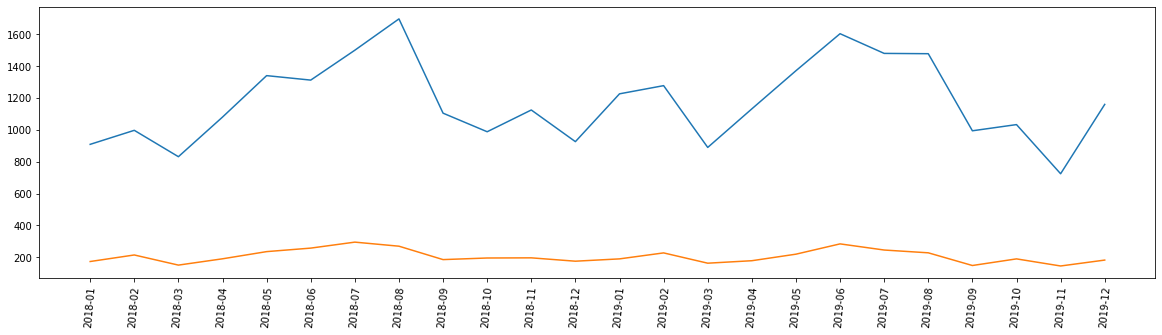

In [ ]:
# # airline = input("What airline (9E, AA, AS, B6, DL, EV, F9, G4, HA, MQ, NK, OH, OO, UA, VX, WN, YV, YX)? ")

# # Subset for carrier selected by user and rows with a NAS delay.
# df_nas = df_delays[(df_delays['carrier'] == airline) & (df_delays['nas_delay'] > 0)]

# Get average of all delays
df_nas = df_delays[df_delays['nas_delay'] > 0]

# Determine mean number of NAS delay minutes by month.
df_nas_means = df_nas.groupby('date')['nas_delay'].mean()
df_nas_medians = df_nas.groupby('date')['nas_delay'].median()

df_nas = pd.merge(df_nas_means, df_nas_medians, on='date')

# Plot NAS delay minutes by month for selected airline.
plt.figure(figsize=(20, 5))
plt.plot(df_nas)
plt.xticks(rotation=85)
plt.show()